In [1]:
# To create python file:
# jupyter nbconvert --to=python lang_model_new.ipynb

import utils.data_import as data_import
import utils.imdb_data as imdb_data
import utils.ml_utils as ml_utils
import model.neural as neural

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd
import numpy as np
import math
#from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm

import importlib

import settings

np.random.seed(123)

/r/ge.unx.sas.com/vol/vol620/u62/ivoliv/.conda/envs/ONE/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
in_notebook = ml_utils.in_ipynb()
print('Running in notebook:', in_notebook)

Running in notebook: True


In [3]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')

if in_notebook:
    import matplotlib.pyplot as plt
    %matplotlib inline

Cuda is available!
Device: Tesla V100-SXM2-16GB


In [4]:
corpus = imdb_data.ImdbCorpus(filename=settings.imdb_file, lines=settings.lines_imbd, vocab_file='vocab.p')

Importing vocab from vocab.p... Done.
Imported vocab:  28,913
Read total of: 50,000 lines from imdb file.
Number of classes: 2: {'negative': 0, 'positive': 1}
Generated train: 35,000 lines
Generated valid: 7,500 lines
Generated test:  7,500 lines


In [5]:
if in_notebook:
    print(corpus.vocab.most_frequent(to=20))
    print(corpus.classes.most_frequent())

[('<unk>', 1733408), ('the', 653597), ('.', 535762), ('a', 318371), ('and', 315184), ('of', 287528), ('to', 265938), ('is', 207019), ('in', 182891), ('i', 149475), ('this', 145807), ('it', 145327), ('that', 132656), ('was', 94346), ('as', 89665), ('for', 85808), ('with', 85765), ('but', 79567), ('movie', 74693), ('film', 65920)]
[('negative', 25000), ('positive', 25000)]


In [6]:
if in_notebook:
    corpus.train.show_stoklist(corpus.vocab, 2)

## sentiment: 1
## text:      although compared with <unk> <unk> this film is in a league of its own . set in post apocalyptic <unk> this film is about <unk> struggle for <unk> he has lost his ability to <unk> and there is a remarkable shortage of women . congratulations luc <unk> <eol> 

## sentiment: 1
## text:      anchors <unk> is an entertaining mgm musical that fans of the genre will enjoy but i <unk> rate it up there with classics like <unk> in the rain or the band wagon . this was the first of three musicals that gene kelly and frank sinatra appeared in together . kelly and sinatra play joe brady and clarence <unk> two sailors on leave in hollywood who befriend a young boy <unk> <unk> introduces them to his attractive young aunt <unk> <unk> a struggling actress who is working as an extra at mgm . though both guys are initially attracted to <unk> she eventually voices a preference to joe but clarence later hooks up with a <unk> <unk> <unk> he learns is from his hometown of brook

In [7]:
corpus.batchify(batch_size=settings.batch_size_imdb, seq_length=settings.window_size_imbd)

Batch size:        100
Sequence length:   300
Batchifying train...
 Number of batches: 350
 Preserved reviews: 35,000
 Matrix size:       torch.Size([105350, 100])
Batchifying valid...
 Number of batches: 75
 Preserved reviews: 7,500
 Matrix size:       torch.Size([22575, 100])
Batchifying test... 
 Number of batches: 75
 Preserved reviews: 7,500
 Matrix size:       torch.Size([22575, 100])


In [8]:
if in_notebook:
    corpus.train.batch_start_end[:10]

In [9]:
if in_notebook:
    corpus.train.show_itoklist(2)
    corpus.train.show_stoklist(corpus.vocab, 2)
    print(corpus.train.batch_matrix[:settings.window_size_imbd,0])
    #df = corpus.train.batch_stats()
    #df.hist()

## sentiment: 1
## text:      [253, 2581, 119, 2, 2, 456, 3936, 27, 44, 28, 2633, 17, 55, 486, 16, 930, 44, 474, 8730, 2, 456, 3936, 27, 681, 2, 2777, 40, 2, 472, 278, 1395, 342, 4302, 23, 2, 38, 247, 27, 28, 1895, 6204, 17, 1668, 16, 7647, 23253, 2, 1]

## sentiment: 1
## text:      [7806, 2, 27, 145, 831, 19760, 712, 149, 2699, 17, 18, 10822, 290, 4240, 160, 1249, 2, 2627, 47, 285, 247, 119, 10827, 185, 2, 44, 18, 9025, 300, 18, 1718, 24257, 16, 456, 130, 18, 60, 17, 409, 8792, 149, 8618, 1369, 38, 8564, 20168, 2677, 44, 434, 16, 1369, 38, 20168, 647, 3320, 24953, 38, 24821, 2, 252, 9007, 93, 2323, 44, 3921, 74, 21055, 28, 430, 2111, 2, 2, 15554, 240, 23, 342, 17410, 430, 7056, 2, 2, 28, 2779, 3853, 74, 27, 715, 24, 145, 779, 275, 19760, 16, 1828, 113, 19363, 79, 695, 4114, 23, 2, 1791, 984, 7944, 28, 13974, 23, 3320, 160, 24821, 722, 24105, 285, 119, 28, 2, 2, 2, 472, 13730, 27, 115, 342, 7141, 17, 9272, 16, 18, 2, 381, 1982, 1686, 40, 721, 466, 712, 397, 1625, 2, 5464, 23, 2, 3320,

In [10]:
train_dl = imdb_data.ImdbTextDataset(corpus.train)
valid_dl = imdb_data.ImdbTextDataset(corpus.valid)
test_dl = imdb_data.ImdbTextDataset(corpus.test)

In [11]:
if in_notebook:
    train = next(iter(train_dl))
    print(train)

(tensor([[  253,  1249,   564,  ...,    24,   456,  1223],
        [ 2581,  9398,  3891,  ...,    28,  3936,     2],
        [  119,  7773,   627,  ..., 14663,  4313,  6015],
        ...,
        [    0,     0,    18,  ...,     0,     0,     0],
        [    0,     0, 15782,  ...,     0,     0,     0],
        [    0,     0,   275,  ...,     0,     0,     0]]), tensor([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0]))


In [12]:
if in_notebook:
    for idx, (x, y) in enumerate(train_dl):
        if idx >= 2:
            break
        print(idx, len(x[:,1]))
        for i in x[:,1]:
            print(corpus.vocab.itos[i], end=' ')
        print('##', corpus.classes.itos[y[1].item()], '##')

0 300
i quit watching <unk> west <unk> after aaron <unk> quit writing and producing . it just <unk> the same . imagine my thrill at seeing a film that he wrote again . it has been a long time - the american <unk> a few good men . his script was a beautiful blend of humor and tragedy . he made a compelling story <unk> and made me <unk> at the same time <unk> tom hanks was incredible as a <unk> texas congressman whose constituents only wanted lower taxes and to keep their guns . not a hard <unk> so he had plenty of time to fool around - and that he did . his office staff looked as if he were at the playboy mansion . like he reportedly <unk> <unk> can teach them to <unk> but you <unk> teach them to grow <unk> <unk> despite his <unk> <unk> which fits right in with a texas <unk> they were fiercely <unk> especially his <unk> amy adams <unk> & former hooters <unk> <unk> <unk> add a rich texas <unk> who wants something done in <unk> played perfectly by julia <unk> and a <unk> cia <unk> superbl

In [13]:
model = neural.class_model_LSTM(vocab_dim=len(corpus.vocab),
                                emb_dim=settings.emb_dim,
                                hidden_dim=settings.hidden_dim,
                                n_layers=settings.num_layers,
                                dropout=settings.dropout,
                                n_classes=corpus.n_classes
                               )

In [14]:
if cuda:
    model = model.cuda()

In [15]:
print(model)

class_model_LSTM(
  (embedding): Embedding(28913, 400)
  (lstm): LSTM(400, 1150, num_layers=3, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=2300, out_features=2, bias=True)
  (dropout): Dropout(p=0.4)
)


In [16]:
if in_notebook:
    x, y = train
    print(x.shape)
    print(y.shape)
    preds = model(x.cuda())
    print(preds.shape)
    print(y)
    print(preds)
    loss_func = nn.CrossEntropyLoss()
    loss = loss_func(preds, y.cuda().long())

torch.Size([300, 100])
torch.Size([100])
torch.Size([100, 2])
tensor([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 0])
tensor([[-1.1585,  1.4205],
        [-0.4210,  0.7204],
        [ 0.1306, -0.9335],
        [-0.9858, -0.7064],
        [-0.9926,  0.5539],
        [ 0.5553,  0.4723],
        [-0.6417,  1.0560],
        [-1.1098,  0.0025],
        [-0.7963,  0.1655],
        [-0.8318,  1.2251],
        [-0.6818, -0.0533],
        [ 0.1853,  0.3120],
        [-0.2240,  0.0055],
        [-0.9088, -1.6686],
        [ 0.4185, -0.7908],
        [ 0.4511, -0.2057],
        [-0.0848,  0.3491],
        [ 0.0031,  0.5372],
        [-0.2153,  0.4052],
        [-0.4473,  0.6796],
        [-0.5870,  0.2751],
        [

In [17]:
model = torch.load('model_weights_imdb.pt')

In [18]:
missclass = []
missclass_next = []
losses = []

In [19]:
from sklearn import utils
def run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
               losses=[], missclass=[]):
    
    opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
    #opt = optim.Adam(model.parameters(), lr=0.001)
    #loss_func = nn.NLLLoss()
    loss_func = nn.CrossEntropyLoss()
    
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.8)
    
    best_val_loss = 1e10
    
    try: # Allow for user interrupt
 
        for epoch in range(1, epochs + 1):
        
            corpus.train.itoklist_df = utils.shuffle(corpus.train.itoklist_df)
            corpus.batchify(batch_size=settings.batch_size_imdb, seq_length=settings.window_size_imbd, 
                            suppress_print=True)
            
            scheduler.step()
            running_loss = 0.0
            running_corrects = 0
            model.train() # turn on training mode

            num_vals = 0
            num_correct = 0

            #pdb.set_trace()

            for x, y in tqdm(train_dl, desc='Train {}/{}'.format(epoch, epochs)):
                opt.zero_grad()
                
                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                preds = model(x)
                loss = loss_func(preds, y.long())

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                opt.step()

                running_loss += loss.item() * x.size(0) / x.size(1)

                _, y_preds = torch.max(preds, dim=1)
                num_correct += torch.sum(y == y_preds).item()
                num_vals += y.size(0)

            #pdb.set_trace()

            missclass_tr = 1 - num_correct / num_vals

            epoch_loss = running_loss / len(train_dl)

            num_vals = 0
            num_correct = 0

            # calculate the validation loss for this epoch
            val_loss = 0.0
            model.eval() # turn on evaluation mode
            
            with torch.no_grad():
                for x, y in tqdm(valid_dl, desc='Valid {}/{}'.format(epoch, epochs)):
                    if cuda:
                        x = x.cuda()
                        y = y.cuda()   
                        
                    preds = model(x)
                    loss = loss_func(preds, y.long())

                    val_loss += loss.item() * x.size(0) / x.size(1)

                    _, y_preds = torch.max(preds, dim=1)
                    num_correct += torch.sum(y == y_preds).item()
                    num_vals += y.size(0)

            #pdb.set_trace()

            missclass_te = 1 - num_correct / num_vals
            val_loss /= len(valid_dl)
            
            missclass.append((missclass_tr, missclass_te))
            losses.append((epoch_loss, val_loss))

            print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Miss: [{:.2%}, {:.2%}]'\
                  .format(epoch, epochs, epoch_loss, val_loss, 
                          missclass_tr, missclass_te))
            sys.stdout.flush()

            if val_loss < best_val_loss:
                print('Improved validation. Saving weights file...', end=' ', flush=True)
                torch.save(model, 'model_weights_imdb_300.pt')
                print('Done.', flush=True)
                best_val_loss = val_loss
            
    except KeyboardInterrupt:
        print('Stopping with latest weights.')
        
    return model, opt, losses, missclass

In [20]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
                                           losses=losses, missclass=missclass)

Train 1/20:   0%|          | 0/350 [00:00<?, ?it/s]/net/nagennas02.unx.sas.com/vol/vol054/cas/ivoliv/projects/speaker_id/model/neural.py:112: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  out, (hid, cel) = self.lstm(emb)
Valid 1/20: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]

Epoch: 1/20, Loss: [0.3553, 1.5029], Miss: [4.12%, 15.20%]
Improved validation. Saving weights file... 

Done.


Valid 2/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 2/20, Loss: [0.1956, 2.1482], Miss: [1.99%, 16.00%]



Valid 3/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 3/20, Loss: [0.1479, 2.3425], Miss: [1.37%, 16.03%]



Valid 4/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 4/20, Loss: [0.1392, 2.3305], Miss: [1.28%, 15.47%]



Valid 5/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 5/20, Loss: [0.1512, 2.6016], Miss: [1.33%, 16.17%]



Valid 6/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 6/20, Loss: [0.1117, 2.4815], Miss: [0.97%, 15.45%]



Valid 7/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 7/20, Loss: [0.1008, 2.4267], Miss: [0.88%, 15.92%]



Valid 8/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 8/20, Loss: [0.0856, 2.3277], Miss: [0.68%, 15.71%]



Valid 9/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 9/20, Loss: [0.0992, 2.6411], Miss: [0.77%, 15.84%]



Valid 10/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 10/20, Loss: [0.0992, 2.5972], Miss: [0.86%, 15.73%]



Valid 11/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 11/20, Loss: [0.0883, 3.1651], Miss: [0.71%, 15.29%]



Valid 12/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 12/20, Loss: [0.0761, 2.5229], Miss: [0.62%, 15.23%]



Valid 13/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 13/20, Loss: [0.0798, 2.9151], Miss: [0.65%, 15.67%]



Valid 14/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 14/20, Loss: [0.0837, 2.6437], Miss: [0.67%, 15.27%]



Valid 15/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 15/20, Loss: [0.0806, 2.5003], Miss: [0.61%, 15.07%]



Valid 16/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 16/20, Loss: [0.0665, 2.7086], Miss: [0.49%, 15.51%]



Valid 17/20: 100%|██████████| 75/75 [00:40<00:00,  1.86it/s]

Epoch: 17/20, Loss: [0.0795, 3.0732], Miss: [0.60%, 15.53%]



Valid 18/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 18/20, Loss: [0.0864, 3.2336], Miss: [0.62%, 15.63%]



Valid 19/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 19/20, Loss: [0.0977, 2.9684], Miss: [0.71%, 16.07%]



Valid 20/20: 100%|██████████| 75/75 [00:40<00:00,  1.85it/s]

Epoch: 20/20, Loss: [0.0818, 2.9165], Miss: [0.59%, 15.21%]


In [21]:
x, y = next(iter(valid_dl))
if cuda:
    x = x.cuda()
    y = y.cuda()
loss_func = nn.CrossEntropyLoss()
preds = model(x)
_, y_preds = torch.max(preds, dim=1)
loss = loss_func(preds, y.long())
loss

/net/nagennas02.unx.sas.com/vol/vol054/cas/ivoliv/projects/speaker_id/model/neural.py:112: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  out, (hid, cel) = self.lstm(emb)


tensor(0.8629, device='cuda:0', grad_fn=<NllLossBackward>)

In [22]:
print(y.shape)
print(y[:])

torch.Size([100])
tensor([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 0, 1], device='cuda:0')


In [23]:
print(y_preds[:])
print(preds)

tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1], device='cuda:0')
tensor([[ 3.4342, -2.0549],
        [-4.8462,  5.8863],
        [ 0.4481,  0.6714],
        [-4.9134,  6.0739],
        [-4.9111,  5.9919],
        [ 3.2857, -2.0364],
        [-4.7708,  5.9538],
        [-4.5555,  5.4884],
        [ 3.2811, -2.0755],
        [-4.9187,  6.0091],
        [-4.9112,  6.0499],
        [-4.9190,  6.0095],
        [ 3.2643, -2.0329],
        [ 3.1808, -1.9745],
        [-4.9212,  6.0151],
        [-2.8726,  4.0308],
        [-4.3684,  5.4877],
        [-4.8027,  5.8680],
        [-4.9648,  6.0747],
        [ 3.2074, -2.0145],
        [-4.8868,  6.0011],
        [-4.8969,  6.0239],
        [-0.3235,  1.3123]

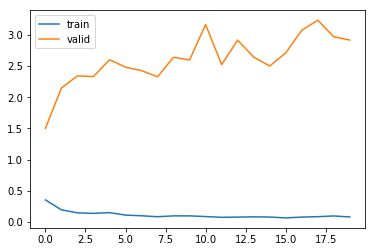

In [24]:
if in_notebook:
    plt.plot(losses)
    plt.legend(['train', 'valid'])

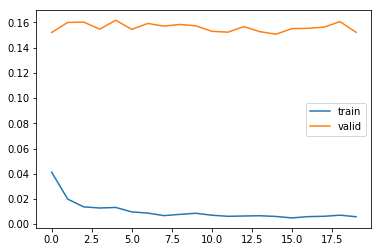

In [25]:
if in_notebook:
    plt.plot(missclass)
    plt.legend(['train', 'valid'])